In [11]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from matplotlib.colors import PowerNorm, SymLogNorm
import numpy as np
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim

def get_ssim_values(imgs):
    ssim_values = []
    for i, img in enumerate(imgs):
        img = img_as_float(img)
        if i == 1:
            img[i] = img[i][3:4]
        elif i == 2:
            img[i][2] = img[i][1]
            img[i][1] = img[i][3]
        else:
            img[i] = img[i][7:8]
    for i, img in enumerate(imgs):
        if i == 0: # Ground truth
            ssim_values.append(1.0000)
            continue
        if i == 1 or i == 2:
            ssim_value = ssim(imgs[0][2], img[2], data_range=img[2].max() - img[2].min())
            ssim_values.append(ssim_value)
            continue
        ssim_value = (ssim(imgs[0][1], img[1], data_range=img[1].max() - img[1].min()) + ssim(imgs[0][2], img[2], data_range=img[2].max() - img[2].min())) / 2
        ssim_values.append(ssim_value)
    return ssim_values
    

def plot_images_comparison(ground_truth_path, double_diff_path, rhapsodie_path, adir_path, aidr_2_path, adir_3_path):
    
    gt_hdulist = fits.open(ground_truth_path)
    double_diff_hdulist = fits.open(double_diff_path)
    rhapsodie_hdulist = fits.open(rhapsodie_path)
    adir_hdulist = fits.open(adir_path)
    adir_2_hdulist = fits.open(aidr_2_path)
    adir_3_hdulist = fits.open(adir_3_path)
    
    gt_imgs = gt_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta
    double_diff_imgs = double_diff_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta
    rhapsodie_imgs = rhapsodie_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta
    adir_imgs = adir_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta
    adir_2_imgs = adir_2_hdulist[0].data[:10] # Only Iu, Ip, theta
    adir_3_imgs = adir_3_hdulist[0].data[:10] # Only Iu, Ip, theta
    
    gt_hdulist.close()
    double_diff_hdulist.close()
    rhapsodie_hdulist.close()
    adir_hdulist.close()
    adir_2_hdulist.close()
    adir_3_hdulist.close()

    mask = (gt_imgs[0] != 0)

    imgs = [gt_imgs, double_diff_imgs, rhapsodie_imgs, adir_imgs, adir_2_imgs, adir_3_imgs]
    method_names = ['Vérité Terrain', 'Double Différence', 'Rhapsodie', 'RJ', 'RD', 'RS']
    titles = [r'$I^u_{res}$', r'$I^u_{disk}$', r'$I^p_{disk}$', r'$\theta$']
    ssim_values = get_ssim_values(imgs)
    for i in range(len(double_diff_imgs)):
        double_diff_imgs[i] = double_diff_imgs[i] * mask
    num_cols = len(method_names)
    num_rows = len(titles)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))
    fig.subplots_adjust(0.1, 0.1, 0.9, 0.9, 0.1, 0.6) # Bottom, top, left, right, wspace, hspace
    for i in range(num_rows):
        if i == 0:
            norm = PowerNorm(gamma=0.25, vmin=0, vmax=10000)
            cmap = 'gist_heat'
        elif i == 1:
            norm = PowerNorm(gamma=0.25, vmin=0, vmax=1000)
            cmap = 'gist_heat'
        elif i == 2:
            norm = PowerNorm(gamma=0.25, vmin=0, vmax=400)
            cmap = 'gist_heat'
        elif i == 3: # Theta
            norm = PowerNorm(gamma=1, vmin=-np.pi/2, vmax=np.pi/2)
            cmap = 'PuOr'
        for j in range(num_cols):
            ax = axs[i, j]
            img = 0 # Default value
            if method_names[j] == 'Double Différence':
                img = imgs[j][i + 2]
                if i == 0:
                    img = imgs[j][i]
            elif method_names[j] == 'Rhapsodie':
                img = imgs[j][i]
                if i == 1:
                    img = imgs[j][3]
                if i == 2 or i == 3:
                    img = imgs[j][i - 1]
            else:
                img = imgs[j][i + 6]
            center = (img.shape[0] // 2, img.shape[1] // 2)
            
            zoom_size = 135
            img = img[center[0] - zoom_size:center[0] + zoom_size, center[1] - zoom_size:center[1] + zoom_size]

            im = ax.imshow(img, cmap=cmap, norm=norm)
            if i == 0:
                ssim_value = ssim_values[j]
                ax.set_title(f"{method_names[j]}\nSSIM: {ssim_value:.4f}")
            if j == 0:
                ax.set_ylabel(titles[i], rotation=0, ha='right')
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add colorbars
        cbar_ax = fig.add_axes([1.006, 0.765 - 0.255 * i, 0.02, 0.24])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.tick_params(labelsize=8)
        fig.subplots_adjust(0, 0, 1, 1, 0, 0)
    fig.savefig('comparison_method.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    

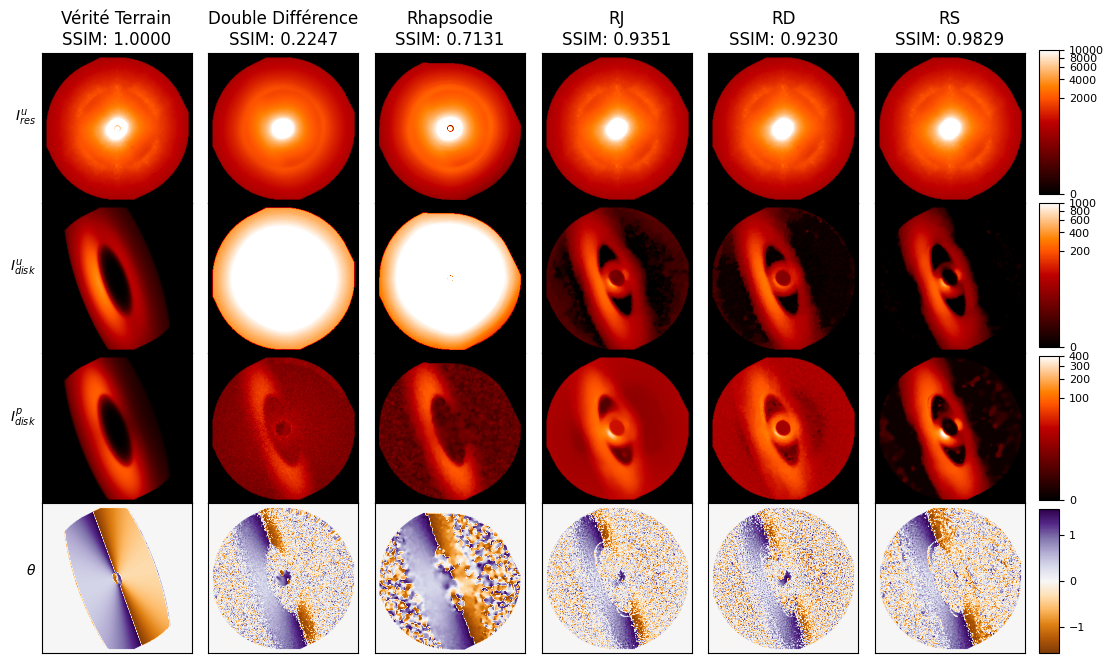

In [12]:
full_base_path = "../test_results/contrast_10e-2.0/"
prima_path = "../test_results/prima/contrast_10e-2.0/"
plot_images_comparison(full_base_path + 'TRUE.fits',
                       full_base_path + 'Results_Separable_DoubleDifference.fits',
                       full_base_path + 'RHAPSODIE.fits',
                       prima_path + 'joint_regul/RHAPSODIE_-0.25736477659795864_-0.6267033073848555.fits', 
                       prima_path + 'disjoint_regul/RHAPSODIE_-1.2707639806535047_-1.34720498248939.fits',
                       prima_path + 'struct_regul/RHAPSODIE_-0.378435549748846_-1.056288065355339_-0.2123298268878793.fits')

In [13]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from matplotlib.colors import PowerNorm
import numpy as np

def plot_images_comparison_pds70(double_diff_path, rhapsodie_path, adir_path, aidr_2_path, adir_3_path):
    
    double_diff_hdulist = fits.open(double_diff_path)
    rhapsodie_hdulist = fits.open(rhapsodie_path)
    adir_hdulist = fits.open(adir_path)
    adir_2_hdulist = fits.open(aidr_2_path)
    adir_3_hdulist = fits.open(adir_3_path)
    
    double_diff_imgs = double_diff_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta
    rhapsodie_imgs = rhapsodie_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta
    adir_imgs = adir_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta
    adir_2_imgs = adir_2_hdulist[0].data[:10] # Only Iu, Ip, theta
    adir_3_imgs = adir_3_hdulist[0].data[:10] # Only Iu, Ip, theta
    
    double_diff_hdulist.close()
    rhapsodie_hdulist.close()
    adir_hdulist.close()
    adir_2_hdulist.close()
    adir_3_hdulist.close()

    # mask = (gt_imgs[0] != 0)
    # for i in range(len(double_diff_imgs)):
    #     double_diff_imgs[i] = double_diff_imgs[i] * mask
    
    imgs = [double_diff_imgs, rhapsodie_imgs, adir_imgs, adir_2_imgs, adir_3_imgs]
    method_names = ['Double Différence', 'Rhapsodie', 'RJ', 'RD', 'RS']
    titles = [r'$I^u_{res}$', r'$I^u_{disk}$', r'$I^p_{disk}$', r'$\theta$']
    
    num_cols = len(method_names)
    num_rows = len(titles)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))
    fig.subplots_adjust(0.1, 0.1, 0.9, 0.9, 0.1, 0.6) # Bottom, top, left, right, wspace, hspace
    for i in range(num_rows):
        if i == 0:
            norm = PowerNorm(gamma=0.5, vmin=0, vmax=1.5)
            cmap = 'gist_heat'
        elif i == 1:
            norm = PowerNorm(gamma=0.5, vmin=0, vmax=1.5)
            cmap = 'gist_heat'
        elif i == 2:
            norm = PowerNorm(gamma=0.5, vmin=0, vmax=0.5)
            cmap = 'gist_heat'
        elif i == 3: # Theta
            norm = PowerNorm(gamma=1, vmin=-np.pi/2, vmax=np.pi/2)
            cmap = 'PuOr'
        for j in range(num_cols):
            ax = axs[i, j]
            img = 0 # Default value
            if method_names[j] == 'Double Différence':
                img = imgs[j][i + 2]
                if i == 0:
                    img = imgs[j][i]
            elif method_names[j] == 'Rhapsodie':
                img = imgs[j][i]
                if i == 1:
                    img = imgs[j][3]
                if i == 2 or i == 3:
                    img = imgs[j][i - 1]
            else:
                img = imgs[j][i + 6]
            center = (img.shape[0] // 2, img.shape[1] // 2)
            
            zoom_size = 130
            img = img[center[0] - zoom_size:center[0] + zoom_size, center[1] - zoom_size:center[1] + zoom_size]

            im = ax.imshow(img, cmap=cmap, norm=norm)
            if i == 0:
                ax.set_title(f"{method_names[j]}")
            if j == 0:
                ax.set_ylabel(titles[i], rotation=0, ha='right')
            ax.set_xticks([])
            ax.invert_yaxis()
            ax.set_yticks([])
        
        # Save the figure as a PDF file
        cbar_ax = fig.add_axes([1.006, 0.765 - 0.255 * i, 0.02, 0.24])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.tick_params(labelsize=8)
        fig.subplots_adjust(0, 0, 1, 1, 0, 0)
    fig.savefig('comparison_pds70.pdf', format='pdf', bbox_inches='tight')
    plt.show()

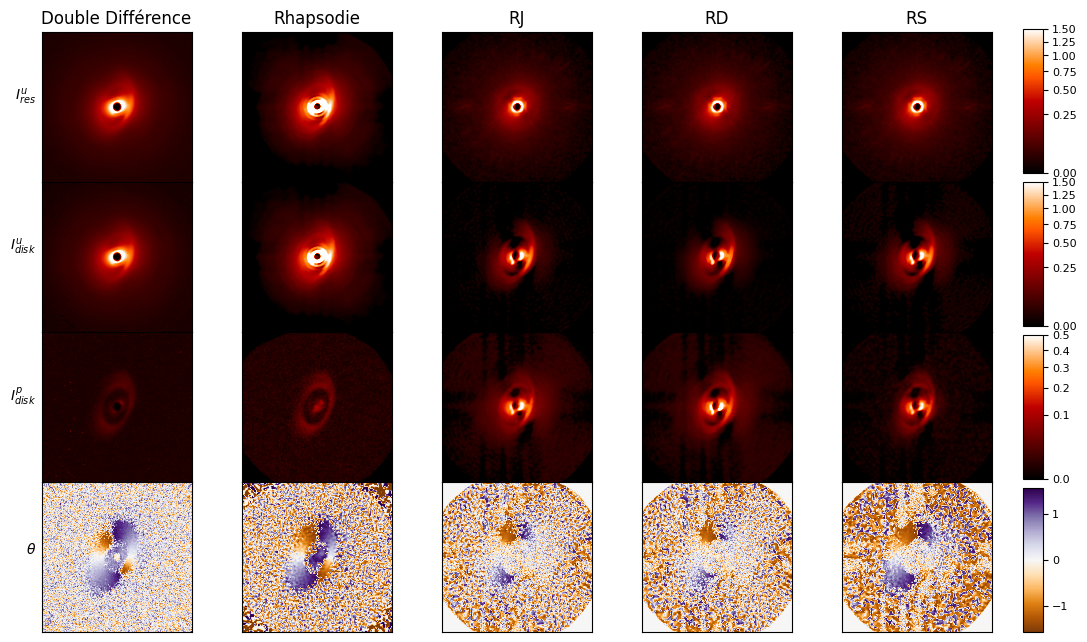

In [14]:
pds70_path = "../pds70_data/"
plot_images_comparison_pds70(pds70_path + 'Results_Separable_DoubleDifference.fits',
                             pds70_path + 'RHAPSODIE.fits',
                             pds70_path + 'results/PADI_pds70_mixed_joint_3.5_-1.0_-0.65.fits',
                             pds70_path + 'results/PADI_pds70_mixed_disjoint_3_3_-2.fits',
                             pds70_path + 'results/PADI_pds70_mixed_struct_3.5_1.75_-1.0_-0.325.fits')

In [84]:
from matplotlib.colors import PowerNorm

import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np

# Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta 
def plot_single_image(file_path, norm=None): # Istar, Iudisk, Ip, theta
    hdulist = fits.open(file_path)
    imgs = hdulist[0].data
    hdulist.close()
    cmap = 'gist_heat'
    f1 = plt.figure()
    f1.set_size_inches(20, 10)
    ax = f1.add_subplot(111)
    ax.imshow(imgs[0], cmap=cmap, norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    f1.subplots_adjust(0, 0, 1, 1, 0, 0)
    f1.savefig('data.pdf', format='pdf')

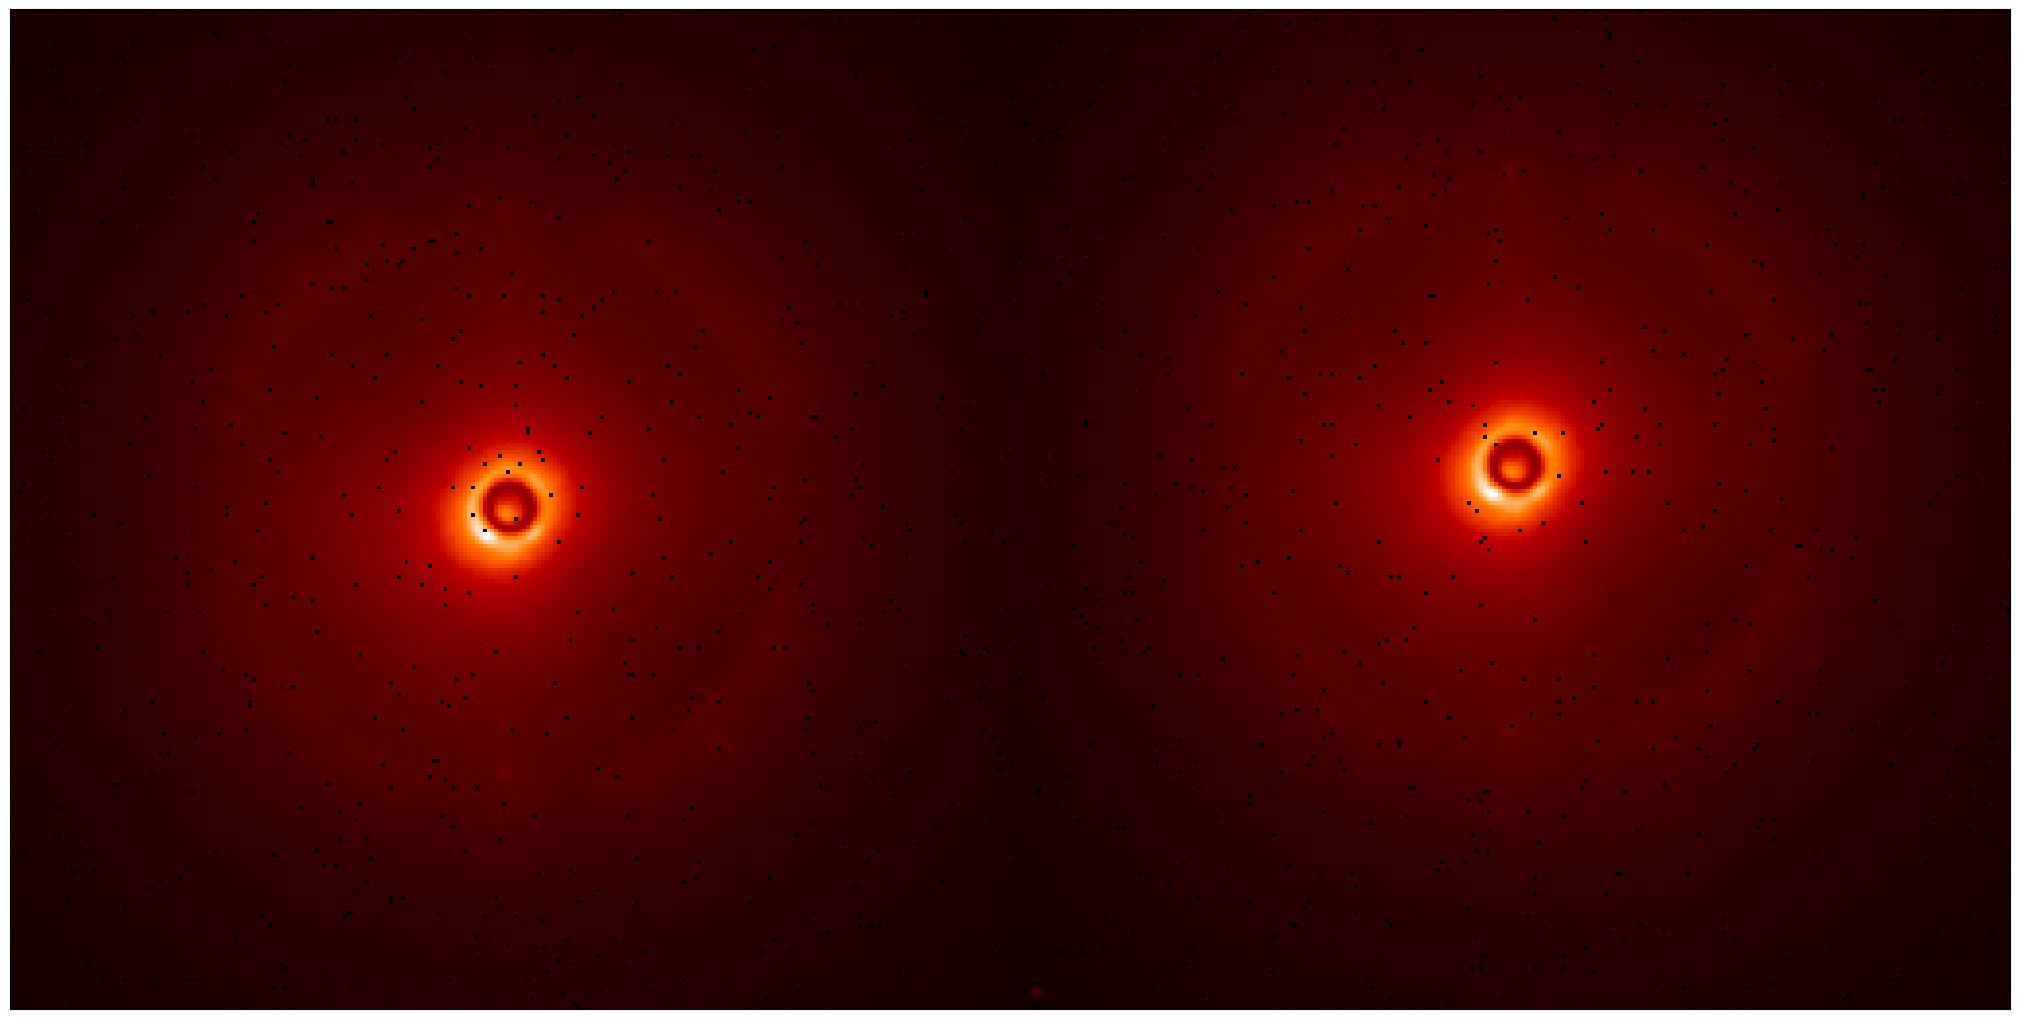

In [85]:
plot_single_image("../test_results/contrast_10e-2.0/DATA.fits", PowerNorm(gamma=0.5))

In [75]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

def plot_polarization_ratio(gt_path, file):
    gt_hdulist = fits.open(gt_path)
    file_hdulist = fits.open(file)

    file_imgs = file_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta
    gt_imgs = gt_hdulist[0].data[:10] # Itot, I_star, I_disk, Q, U, Iu, Iu_star, Iu_disk, Ip, theta    
    
    file_hdulist.close()
    gt_hdulist.close()
    
    # norm = PowerNorm(gamma=0.5, vmin=10, vmax=8000)
    # cmap = 'PuOr'
    # norm = PowerNorm(gamma=0.25, vmin=0, vmax=80)
    # cmap = 'gist_heat'
    # norm = PowerNorm(gamma=0.25)
    # cmap = 'gist_heat'
    # im = ax.imshow(img, cmap=cmap, norm=norm)
    # Add colorbars
    # plt.imshow(imgs[8] / (imgs[7] + imgs[8]), cmap='viridis')
    fig, axs = plt.subplots(1, 3, figsize=(14, 14))
    norm = LogNorm(vmax=1)
    for i in range(3):
        ax = axs[i]
        if i == 0:
            ax.set_title("Ground Truth Polar ratio")
            patrick = ax.imshow(gt_imgs[8] / gt_imgs[2], cmap='gist_heat', norm=norm)
            cbar = plt.colorbar(patrick, ax=ax, fraction=0.046, pad=0.04, norm=norm)
        if i == 1:
            ax.set_title("ADIR Polar ratio")
            patrick = ax.imshow(file_imgs[8] / file_imgs[2], cmap='gist_heat', norm=norm)
            cbar = plt.colorbar(patrick, ax=ax, fraction=0.046, pad=0.04, norm=norm)
        if i == 2:
            ax.set_title("ADIR - Ground Truth Polar ratio")
            patrick = ax.imshow((file_imgs[8] / file_imgs[2]) - (gt_imgs[8] / gt_imgs[2]), cmap='RdBu', norm=SymLogNorm(linthresh=1e-1, vmin=-1, vmax=1))
            cbar = plt.colorbar(patrick, ax=ax, fraction=0.046, pad=0.04, norm=norm)
    plt.tight_layout()
    plt.show()

C:\Users\vince\AppData\Local\Temp\ipykernel_27004\1475038247.py:30: RuntimeWarning: invalid value encountered in divide
  patrick = ax.imshow(gt_imgs[8] / gt_imgs[2], cmap='gist_heat', norm=norm)
C:\Users\vince\AppData\Local\Temp\ipykernel_27004\1475038247.py:34: RuntimeWarning: invalid value encountered in divide
  patrick = ax.imshow(file_imgs[8] / file_imgs[2], cmap='gist_heat', norm=norm)
C:\Users\vince\AppData\Local\Temp\ipykernel_27004\1475038247.py:38: RuntimeWarning: invalid value encountered in divide
  patrick = ax.imshow((file_imgs[8] / file_imgs[2]) - (gt_imgs[8] / gt_imgs[2]), cmap='RdBu', norm=SymLogNorm(linthresh=1e-1, vmin=-1, vmax=1))


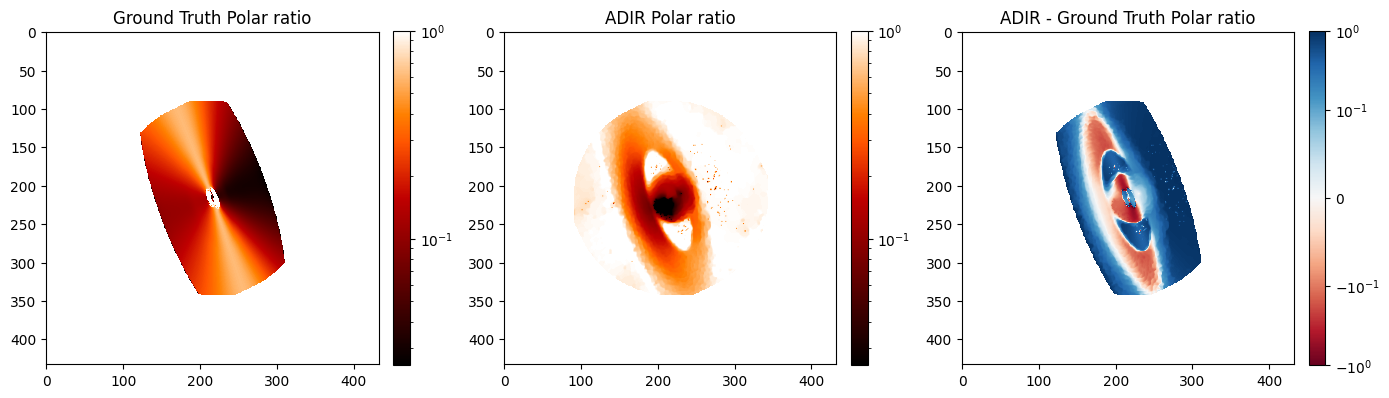

In [76]:
full_base_path = "../test_results/contrast_10e-2.0/"
results_path = "rhapsodie_method_results/max_iter_700/"


plot_polarization_ratio(full_base_path + 'TRUE.fits',
                        full_base_path + results_path + 'RHAPSODIE_0.7761932175073487_-3.821280230932202.fits')